In [1]:
from __future__ import division
import math
import pickle
import requests
import numpy as np
import tensorflow as tf
from itertools import product
from random import sample
from string import lowercase, digits
# from captcha.image import ImageCaptcha

In [2]:
from StringIO import StringIO
import tempfile
from PIL import Image
import py4j
from py4j.java_gateway import JavaGateway, GatewayParameters

### .初始化验证生成控件

In [3]:
port = py4j.java_gateway.launch_gateway(classpath='/usr/lib/jvm/lib/kaptcha-2.3.2.jar')
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=port))
constants = gateway.jvm.com.google.code.kaptcha.Constants
ImageIO = gateway.jvm.javax.imageio.ImageIO
filename = tempfile.mktemp(suffix='.jpg')

In [4]:
fontSizeList = ['39', '40', '41', '42', '43', '44', '45']
fontNameList = [
    'Ubuntu Light',
    'Ubuntu Light Italic',
    'Ubuntu Regular',
    'Ubuntu Regular Italic',
    'Lato-Hairline',
    'lmroman8-italic', 
    'lmmonocaps10-regular',
    'Loma-Oblique',
    'Norasi-Oblique',
    'Umpush-Light',
]
kaptchaList = []
for fontSize, fontName in product(fontSizeList, fontNameList):
    properties = gateway.jvm.java.util.Properties()
    properties.put(constants.KAPTCHA_IMAGE_WIDTH, '223')
    properties.put(constants.KAPTCHA_IMAGE_HEIGHT, '50')
    properties.put(constants.KAPTCHA_TEXTPRODUCER_FONT_SIZE, fontSize)
    properties.put(constants.KAPTCHA_TEXTPRODUCER_FONT_NAMES, fontName)
    properties.put(constants.KAPTCHA_BORDER, 'no')
    kaptchaConfig = gateway.jvm.com.google.code.kaptcha.util.Config(properties)
    kaptcha = gateway.jvm.com.google.code.kaptcha.impl.DefaultKaptcha()
    kaptcha.setConfig(kaptchaConfig)
    kaptchaList.append(kaptcha)

### .定义模型参数

In [5]:
index = 1
width = 223
height = 50
# charset = '0123456789'
# charset = '0123456789' + lowercase
charset = digits + lowercase
# captchaLength = 4
captchaLength = 1
imageSize = width * height
alpha = 1e-3

### .定义相关函数

In [6]:
# def getCode():
#     return ''.join(map(
#         lambda x: charset[x], 
#         # np.random.randint(0, len(charset), captchaLength)  
#         np.random.randint(0, len(charset), 4) # changed
#     ))
# captcha = ImageCaptcha(width=width, height=height)

In [7]:
# def getData(n = 10):    
#     codeList = [getCode() for _ in range(n)]
#     imageList = map(lambda code: captcha.generate_image(code), codeList)
#     return imageList, codeList

In [8]:
def getCode():
    return kaptcha.createText()

In [9]:
def generateImage(code):
    kaptcha = sample(kaptchaList, 1)[0]
    image = kaptcha.createImage(code)
    f = gateway.jvm.java.io.File(filename)    
    ImageIO.write(image, 'JPG', f)
    image = Image.open(filename)
    return image

In [10]:
def getData(n = 10):    
    codeList = [getCode() for _ in range(n)]
    imageList = map(lambda code: generateImage(code), codeList)
    return imageList, codeList

In [11]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)                                                                                                     
    return tf.Variable(initial)   

In [12]:
def bias_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)   

In [13]:
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [14]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [15]:
# def imageToVertor(image):
#     """ 将图片转化为向量表示 """
#     image = image.convert("L")
#     image = np.asarray(image)
#     image = image.reshape([width * height]) / 255
#     return image

In [16]:
def imageToVertor(image):
    """ 将图片转化为向量表示 """
    width = image.width
    height = image.height
    image = image.convert("L")
    image = np.asarray(image)
    image = image.reshape([width * height]) / 255
    return image

In [17]:
def codeToVertor(code):
    """ 将验证码转化为向量表示 """
    labels = np.zeros([captchaLength, len(charset)])
    for i in range(captchaLength):
        labels[i, charset.index(code[i])] = 1
    return labels.reshape(len(charset) * captchaLength)

wa33d


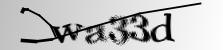

In [18]:
# 测试验证码
code = getCode()
print code
generateImage(code)

### .定义神经网络结构

In [19]:
# 定义输入输出
x = tf.placeholder(tf.float32, shape=[None, imageSize])
y = tf.placeholder(tf.float32, shape=[None, len(charset) * captchaLength])   
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, shape=[-1, width, height, 1])

In [20]:
# 定义第一层卷积
conv_layer1_weight = weight_variable([5, 5, 1, 32])
conv_layer1_bias = bias_variable([32])
pool_layer1 = max_pool(
    tf.nn.relu(conv2d(x_image, conv_layer1_weight) + conv_layer1_bias))

In [21]:
# 定义第二层卷积
conv_layer2_weight = weight_variable([5, 5, 32, 64])
conv_layer2_bias = bias_variable([64])
pool_layer2 = max_pool(
    tf.nn.relu(conv2d(pool_layer1, conv_layer2_weight) + conv_layer2_bias)) 

In [22]:
# 定义第三层卷积
conv_layer3_weight = weight_variable([5, 5, 64, 64])
conv_layer3_bias = bias_variable([64])
pool_layer3 = max_pool(
    tf.nn.relu(conv2d(pool_layer2, conv_layer3_weight) + conv_layer3_bias))

In [23]:
lastWidth = int(math.ceil(width / 8))
lastHeight = int(math.ceil(height / 8))
lastWidth, lastHeight

(28, 7)

In [24]:
# 定义全连接层
fc_layer_weight = weight_variable([lastWidth * lastHeight * 64, 1024])
fc_layer_bias = bias_variable([1024])
pool_layer3_flat = tf.reshape(pool_layer3, [-1, lastWidth * lastHeight * 64])
fc_layer = tf.nn.relu(tf.add(tf.matmul(pool_layer3_flat, fc_layer_weight), fc_layer_bias))

In [25]:
# Dropout层
fc_layer_drop = tf.nn.dropout(fc_layer, keep_prob)

In [26]:
# Readout层(输出层)
output_layer_weight = weight_variable([1024, len(charset) * captchaLength])   
output_layer_bias = bias_variable([len(charset) * captchaLength])              
y_conv = tf.add(tf.matmul(fc_layer_drop, output_layer_weight), output_layer_bias)

In [27]:
# 定义输出函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
prediction = tf.argmax(tf.reshape(y_conv, [-1, captchaLength, len(charset)]), 2)
correct = tf.argmax(tf.reshape(y, [-1, captchaLength, len(charset)]), 2)                                                           
correct_prediction = tf.equal(prediction, correct)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### .训练模型

In [28]:
# 初始化session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [29]:
for step in range(1, 3000):
    imageList, codeList = getData(100)
    codeList = map(lambda x: x[index], codeList) # changed 
    x_data = map(imageToVertor, imageList)
    y_data = map(codeToVertor, codeList)
    _, l, a = session.run([optimizer, loss, accuracy], feed_dict={x: x_data, y: y_data, keep_prob: .75})
    saver.save(session, 'model/%s/model' % index, global_step=step)
    print '[%d]: loss: %f accuracy: %f' % (step, l, a)

[1]: loss: 0.690309 accuracy: 0.000000
[2]: loss: 0.567669 accuracy: 0.000000
[3]: loss: 0.312993 accuracy: 0.020000


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 908, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 1067, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40817)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40817)
Traceback (most recent call last):
  File "/usr/local/lib/python2

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40817)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40817)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:40817)
Traceback (most recent call last):
  File "/usr/local/lib/python2

KeyboardInterrupt: 

In [ ]:
nodes = {
    'x': x.name,
    'y': y.name,
    'prediction': prediction.name,
    'keep_prob': keep_prob.name,
    'loss': loss.name
}
pickle.dump(nodes, open('model/%s/nodes.pk' % index, 'wb'))

### .测试模型效果

#### (1). 训练集测试

In [ ]:
imageList, codeList = getData(1)
x_data = map(imageToVertor, imageList)
y_data = map(codeToVertor, codeList)
p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
print 'code:', codeList[0]
print 'prediction:', map(lambda x: charset[x], p[0])
print 'loss:', l
imageList[0]

#### (2). 实际测试

In [ ]:
# url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
# response = requests.get(url)
# image = Image.open(StringIO(response.content))
# imageList, codeList = [image], ['ca358']
# x_data = map(imageToVertor, imageList)
# y_data = map(codeToVertor, codeList)
# p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
# print 'prediction:', map(lambda x: charset[x], p[0])
# print 'loss:', l
# image

In [ ]:
url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
response = requests.get(url)
image = Image.open(StringIO(response.content))
imageList = [image]
x_data = map(imageToVertor, imageList)
p = session.run(prediction, feed_dict={x: x_data, keep_prob: 1})
print 'prediction:', map(lambda x: charset[x], p[0])
image

In [ ]:
saver.save(session, "/tmp/model.ckpt")

In [ ]:
nodes = {
    'x': x.name,
    'y': y.name,
    'prediction': prediction.name,
    'keep_prob': keep_prob.name,
    'loss': loss.name,
    'output_layer_weight': output_layer_weight.name
}
pickle.dump(nodes, open('/tmp/nodes.pk', 'wb'))

In [ ]:
url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
response = requests.get(url)
image = Image.open(StringIO(response.content))

In [ ]:
imageList = [image]
x_data = map(imageToVertor, imageList)
p = session.run(prediction, feed_dict={x: x_data, keep_prob: .75})
print 'prediction:', map(lambda x: charset[x], p[0])
image

In [ ]:
w = session.run(output_layer_weight)

In [ ]:
import tensorflow as tf
saver = tf.train.Saver()

In [32]:
saver.save?

In [33]:
tf.train.Saver?

In [35]:
saver.save(session, '/tmp/1/model')

'/tmp/1/model'